In [1]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import os
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertModel, BertForSequenceClassification

import numpy as np
import torch.nn as nn
from sklearn.metrics import confusion_matrix
from transformers import AutoTokenizer, AutoModelForMaskedLM, AutoModel
from keras.preprocessing.sequence import pad_sequences

device = torch.device("cpu")

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
cache = '/mnt/raid1/eliza/TEXT_MINING/trans_cache'
os.environ['TRANSFORMERS_CACHE'] = cache

scibert = 'allenai/scibert_scivocab_uncased'
biomedbert = 'microsoft/BiomedNLP-BiomedBERT-base-uncased-abstract-fulltext'
biobert = 'dmis-lab/biobert-base-cased-v1.2'

models_path = '/mnt/raid1/eliza/TEXT_MINING/create_results_for_ML/models/fine_tuning'

df = pd.read_csv("data/manual_curation/eval.csv")
sentences = df["SENTENCE"]
labels = df["LABEL"]
labels = labels.astype(int)

2025-03-20 13:52:49.981306: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-20 13:52:50.024271: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-03-20 13:52:50.024307: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-03-20 13:52:50.025538: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-20 13:52:50.032205: I tensorflow/core/platform/cpu_feature_guar

In [2]:
#  Scibert (LSTM Linear), BiomedBERT (All), Biobert (CNN)

In [3]:
MAX_LEN = 128
BATCH_SIZE = 64

tokenizer_sci_lstm = BertTokenizer.from_pretrained(scibert,cache_dir=cache,do_lower_case=True,truncation=True)
model_sci_lstm = BertForSequenceClassification.from_pretrained(scibert, cache_dir= cache, num_labels= 2,  output_attentions=False, output_hidden_states=False)

tokenizer_sci_linear = BertTokenizer.from_pretrained(scibert,cache_dir=cache,do_lower_case=True,truncation=True)
model_sci_linear = BertForSequenceClassification.from_pretrained(scibert, cache_dir= cache, num_labels= 2,  output_attentions=False, output_hidden_states=False)

tokenizer_med_linear = BertTokenizer.from_pretrained(biomedbert,cache_dir=cache,do_lower_case=True,truncation=True)
model_med_linear = BertForSequenceClassification.from_pretrained(biomedbert, cache_dir=cache, num_labels=2, output_attentions=False, output_hidden_states=False)

tokenizer_med_lstm = BertTokenizer.from_pretrained(biomedbert,cache_dir=cache,do_lower_case=True,truncation=True)
model_med_lstm = BertForSequenceClassification.from_pretrained(biomedbert, cache_dir=cache, num_labels=2, output_attentions=False, output_hidden_states=False)

tokenizer_med_cnn = BertTokenizer.from_pretrained(biomedbert,cache_dir=cache,do_lower_case=True,truncation=True)
model_med_cnn = BertForSequenceClassification.from_pretrained(biomedbert, cache_dir=cache, num_labels=2, output_attentions=False, output_hidden_states=False)

tokenizer_bio_cnn = BertTokenizer.from_pretrained(biobert,cache_dir=cache,do_lower_case=True,truncation=True)
model_bio_cnn = BertForSequenceClassification.from_pretrained(biobert, cache_dir=cache, num_labels=2, output_attentions=False, output_hidden_states=False)

model_sci_lstm.to(device)
model_sci_linear.to(device)
model_med_linear.to(device)
model_med_lstm.to(device)
model_med_cnn.to(device)
model_bio_cnn.to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at allenai/scibert_scivocab_uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at allenai/scibert_scivocab_uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at microsoft/BiomedNLP-BiomedBERT-base-uncased-abstract-fulltext and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification w

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [4]:
# padding for biomedbert linear
tokenize_val_med_linear = sentences.apply((lambda x: tokenizer_med_linear.encode(x, add_special_tokens=True)))
padded_val_med_linear = np.array([i + [0]*(MAX_LEN-len(i)) for i in tokenize_val_med_linear.values])

attention_mask_val_med_linear = np.where(padded_val_med_linear != 0, 1, 0)

input_ids_val_med_linear = torch.tensor(padded_val_med_linear)  
attention_mask_val_med_linear = torch.tensor(attention_mask_val_med_linear)
validation_labels_med_linear = torch.tensor(labels)
validation_inputs_med_linear = torch.tensor(input_ids_val_med_linear)
validation_masks_med_linear = torch.tensor(attention_mask_val_med_linear)

validation_data_med_linear = TensorDataset(validation_inputs_med_linear, validation_masks_med_linear, validation_labels_med_linear)
validation_sampler_med_linear = SequentialSampler(validation_data_med_linear)
validation_dataloader_med_linear = DataLoader(validation_data_med_linear, sampler=validation_sampler_med_linear, batch_size=BATCH_SIZE)

# padding for biomedbert lstm
tokenize_val_med_lstm = sentences.apply((lambda x: tokenizer_med_lstm.encode(x, add_special_tokens=True)))
padded_val_med_lstm = np.array([i + [0]*(MAX_LEN-len(i)) for i in tokenize_val_med_lstm.values])

attention_mask_val_med_lstm = np.where(padded_val_med_lstm != 0, 1, 0)

input_ids_val_med_lstm = torch.tensor(padded_val_med_lstm)  
attention_mask_val_med_lstm = torch.tensor(attention_mask_val_med_lstm)
validation_labels_med_lstm = torch.tensor(labels)
validation_inputs_med_lstm = torch.tensor(input_ids_val_med_lstm)
validation_masks_med_lstm = torch.tensor(attention_mask_val_med_lstm)

validation_data_med_lstm = TensorDataset(validation_inputs_med_lstm, validation_masks_med_lstm, validation_labels_med_lstm)
validation_sampler_med_lstm = SequentialSampler(validation_data_med_lstm)
validation_dataloader_med_lstm = DataLoader(validation_data_med_lstm, sampler=validation_sampler_med_lstm, batch_size=BATCH_SIZE)

# padding for biomedbert cnn
tokenize_val_med_cnn = sentences.apply((lambda x: tokenizer_med_cnn.encode(x, add_special_tokens=True)))
padded_val_med_cnn = np.array([i + [0]*(MAX_LEN-len(i)) for i in tokenize_val_med_cnn.values])

attention_mask_val_med_cnn = np.where(padded_val_med_cnn != 0, 1, 0)

input_ids_val_med_cnn = torch.tensor(padded_val_med_cnn)  
attention_mask_val_med_cnn = torch.tensor(attention_mask_val_med_cnn)
validation_labels_med_cnn = torch.tensor(labels)
validation_inputs_med_cnn = torch.tensor(input_ids_val_med_cnn)
validation_masks_med_cnn = torch.tensor(attention_mask_val_med_cnn)

validation_data_med_cnn = TensorDataset(validation_inputs_med_cnn, validation_masks_med_cnn, validation_labels_med_cnn)
validation_sampler_med_cnn = SequentialSampler(validation_data_med_cnn)
validation_dataloader_med_cnn = DataLoader(validation_data_med_cnn, sampler=validation_sampler_med_cnn, batch_size=BATCH_SIZE)

# padding for scibert linear
tokenize_val_sci_linear = sentences.apply((lambda x: tokenizer_sci_linear.encode(x, add_special_tokens=True)))
padded_val_sci_linear = np.array([i + [0]*(MAX_LEN-len(i)) for i in tokenize_val_sci_linear.values])

attention_mask_val_sci_linear = np.where(padded_val_sci_linear != 0, 1, 0)

input_ids_val_sci_linear = torch.tensor(padded_val_sci_linear)  
attention_mask_val_sci_linear = torch.tensor(attention_mask_val_sci_linear)
validation_labels_sci_linear = torch.tensor(labels)
validation_inputs_sci_linear = torch.tensor(input_ids_val_sci_linear)
validation_masks_sci_linear = torch.tensor(attention_mask_val_sci_linear)

validation_data_sci_linear = TensorDataset(validation_inputs_sci_linear, validation_masks_sci_linear, validation_labels_sci_linear)
validation_sampler_sci_linear = SequentialSampler(validation_data_sci_linear)
validation_dataloader_sci_linear = DataLoader(validation_data_sci_linear, sampler=validation_sampler_sci_linear, batch_size=BATCH_SIZE)

# padding for scibert lstm
tokenize_val_sci_lstm = sentences.apply((lambda x: tokenizer_sci_lstm.encode(x, add_special_tokens=True)))
padded_val_sci_lstm = np.array([i + [0]*(MAX_LEN-len(i)) for i in tokenize_val_sci_lstm.values])

attention_mask_val_sci_lstm = np.where(padded_val_sci_lstm != 0, 1, 0)

input_ids_val_sci_lstm = torch.tensor(padded_val_sci_lstm)  
attention_mask_val_sci_lstm = torch.tensor(attention_mask_val_sci_lstm)
validation_labels_sci_lstm = torch.tensor(labels)
validation_inputs_sci_lstm = torch.tensor(input_ids_val_sci_lstm)
validation_masks_sci_lstm = torch.tensor(attention_mask_val_sci_lstm)

validation_data_sci_lstm = TensorDataset(validation_inputs_sci_lstm, validation_masks_sci_lstm, validation_labels_sci_lstm)
validation_sampler_sci_lstm = SequentialSampler(validation_data_sci_lstm)
validation_dataloader_sci_lstm = DataLoader(validation_data_sci_lstm, sampler=validation_sampler_sci_lstm, batch_size=BATCH_SIZE)

# padding for biobert cnn
tokenize_val_bio_cnn = sentences.apply((lambda x: tokenizer_bio_cnn.encode(x, add_special_tokens=True)))
padded_val_bio_cnn = np.array([i + [0]*(MAX_LEN-len(i)) if len(i) < MAX_LEN else i[:MAX_LEN] for i in tokenize_val_bio_cnn.values])

attention_mask_val_bio_cnn = np.where(padded_val_bio_cnn != 0, 1, 0)

input_ids_val_bio_cnn = torch.tensor(padded_val_bio_cnn)  
attention_mask_val_bio_cnn = torch.tensor(attention_mask_val_bio_cnn)
validation_labels_bio_cnn = torch.tensor(labels)
validation_inputs_bio_cnn = torch.tensor(input_ids_val_bio_cnn)
validation_masks_bio_cnn = torch.tensor(attention_mask_val_bio_cnn)

validation_data_bio_cnn = TensorDataset(validation_inputs_bio_cnn, validation_masks_bio_cnn, validation_labels_bio_cnn)
validation_sampler_bio_cnn = SequentialSampler(validation_data_sci_lstm)
validation_dataloader_bio_cnn = DataLoader(validation_data_bio_cnn, sampler=validation_sampler_bio_cnn, batch_size=BATCH_SIZE)

In [5]:
# BiomedBERT LSTM
class CustomModel_med_LSTM(nn.Module):
    def __init__(self, bert_model, hidden_dim, num_classes):
        super(CustomModel_med_LSTM, self).__init__()
        self.bert_model = BertModel.from_pretrained(biomedbert)
        self.dropout = nn.Dropout(0.3)
        self.lstm = nn.LSTM(768, hidden_dim, num_layers=1, batch_first=True)
        self.classifier = nn.Linear(128, num_classes)

    def forward(self, input_ids, attention_mask, labels=None):
        outputs = self.bert_model(input_ids=input_ids, attention_mask=attention_mask)
        hidden_state = outputs.last_hidden_state
        hidden_state = self.dropout(hidden_state)
        _, (hidden, _) = self.lstm(hidden_state)
        logits = self.classifier(hidden[-1])
        return logits

# Scibert LSTM
class CustomModel_sci_LSTM(nn.Module):
    def __init__(self, bert_model, hidden_dim, num_classes):
        super(CustomModel_sci_LSTM, self).__init__()
        self.bert_model = BertModel.from_pretrained(scibert)
        self.dropout = nn.Dropout(0.3)
        self.lstm = nn.LSTM(768, hidden_dim, num_layers=1, batch_first=True)
        self.classifier = nn.Linear(128, num_classes)

    def forward(self, input_ids, attention_mask, labels=None):
        outputs = self.bert_model(input_ids=input_ids, attention_mask=attention_mask)
        hidden_state = outputs.last_hidden_state
        hidden_state = self.dropout(hidden_state)
        _, (hidden, _) = self.lstm(hidden_state)
        logits = self.classifier(hidden[-1])
        return logits
        
num_filters = 128 
num_classes = 2  
        
# BiomedBERT CNN
class CustomModel_med_CNN(nn.Module):
    def __init__(self, bert_model, num_filters, num_classes):
        super(CustomModel_med_CNN, self).__init__()
        self.bert_model = BertModel.from_pretrained(biomedbert)
        self.conv1d = nn.Conv1d(in_channels=768, out_channels=num_filters, kernel_size=3)
        self.classifier = nn.Linear(num_filters, num_classes)
        self.dropout = nn.Dropout(0.3)

    def forward(self, input_ids, attention_mask, labels=None):
        outputs = self.bert_model(input_ids=input_ids, attention_mask=attention_mask)
        hidden_state = outputs.last_hidden_state
        hidden_state = hidden_state.permute(0, 2, 1)  # Shape: [batch_size, hidden_size, sequence_length]
        
        conv_output = self.conv1d(hidden_state)
        conv_output = F.relu(conv_output)
        pooled_output = F.max_pool1d(conv_output, conv_output.shape[2])
        flatten_output = pooled_output.view(pooled_output.shape[0], -1)
        logits = self.classifier(self.dropout(flatten_output))

        if labels is not None:
            loss = F.cross_entropy(logits.view(-1, 2), labels.view(-1))
            return loss, logits
        else:
            return logits
            
# Biobert CNN
class CustomModel_bio_CNN(nn.Module):
    def __init__(self, bert_model, num_filters, num_classes):
        super(CustomModel_bio_CNN, self).__init__()
        self.bert_model = BertModel.from_pretrained(biobert)
        self.conv1d = nn.Conv1d(in_channels=768, out_channels=num_filters, kernel_size=3)
        self.classifier = nn.Linear(num_filters, num_classes)
        self.dropout = nn.Dropout(0.3)

    def forward(self, input_ids, attention_mask, labels=None):
        outputs = self.bert_model(input_ids=input_ids, attention_mask=attention_mask)
        hidden_state = outputs.last_hidden_state
        hidden_state = hidden_state.permute(0, 2, 1)  # Shape: [batch_size, hidden_size, sequence_length]
        
        conv_output = self.conv1d(hidden_state)
        conv_output = F.relu(conv_output)
        pooled_output = F.max_pool1d(conv_output, conv_output.shape[2])
        flatten_output = pooled_output.view(pooled_output.shape[0], -1)
        logits = self.classifier(self.dropout(flatten_output))

        if labels is not None:
            loss = F.cross_entropy(logits.view(-1, 2), labels.view(-1))
            return loss, logits
        else:
            return logits

model_sci_linear.load_state_dict(torch.load(models_path + '/Scibert/linear_ft.pt'), strict = False)
model_sci_linear.to(device)

model_sci_lstm = CustomModel_sci_LSTM(model_sci_lstm, hidden_dim=128, num_classes=2)
model_sci_lstm.load_state_dict(torch.load(models_path + '/Scibert/lstm_ft.h5'), strict=True)

model_med_linear.load_state_dict(torch.load(models_path + '/BiomedBERT/linear_ft.pt'), strict = False)
model_med_linear.to(device)

model_med_lstm = CustomModel_med_LSTM(model_med_lstm, hidden_dim=128, num_classes=2)
model_med_lstm.load_state_dict(torch.load(models_path + '/BiomedBERT/lstm_ft.h5'), strict=True)

model_med_cnn = CustomModel_med_CNN(model_med_cnn, num_filters, num_classes)
model_med_cnn.load_state_dict(torch.load(models_path + '/BiomedBERT/cnn_ft.h5'), strict=True)

model_bio_cnn = CustomModel_bio_CNN(model_bio_cnn, num_filters, num_classes)
model_bio_cnn.load_state_dict(torch.load(models_path + '/Biobert/cnn_ft.h5'), strict=True)

# Set the models to evaluation mode
model_sci_linear.eval()
model_sci_lstm.eval()
model_med_linear.eval()
model_med_lstm.eval()
model_med_cnn.eval()
model_bio_cnn.eval()

CustomModel_bio_CNN(
  (bert_model): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [6]:
# All combos

In [7]:
from itertools import combinations
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

models = [
    ('Scibert-Linear', model_sci_linear, validation_dataloader_sci_linear),
    ('Scibert-LSTM', model_sci_lstm, validation_dataloader_sci_lstm),
    ('BiomedBERT-Linear', model_med_linear, validation_dataloader_med_linear),
    ('BiomedBERT-LSTM', model_med_lstm, validation_dataloader_med_lstm),
    ('BiomedBERT-CNN', model_med_cnn, validation_dataloader_med_cnn),
    ('Biobert-CNN', model_bio_cnn, validation_dataloader_bio_cnn)
]

def get_model_predictions(name, model, dataloader):
    all_logits = []
    validation_labels = []
    model.eval()
    with torch.no_grad():
        for batch in dataloader:
            input_ids, input_mask, label_ids = batch
            input_ids = input_ids.to(device)
            input_mask = input_mask.to(device)
            label_ids = label_ids.to(device)

            outputs = model(input_ids, input_mask)
            if 'Linear' in name:
                logits = outputs.logits
            else:
                logits = outputs  # Directly assign outputs to logits

            all_logits.append(logits)
            validation_labels.extend(label_ids.tolist())

    # Consolidate logits into a single tensor
    all_logits = torch.cat(all_logits, dim=0)
    return all_logits, validation_labels

pairs = list(combinations(models, 2))

# Create a DataFrame to store results
results_df = pd.DataFrame(columns=[
    'Ensemble',
    'Accuracy',
    'Precision',
    'Recall',
    'F1 Score',
    'Specificity'
])

for (name1, model1, loader1), (name2, model2, loader2) in pairs:
    print(f"\nEnsemble: {name1} + {name2}")
    
    # Get predictions for both models
    logits1, labels1 = get_model_predictions(name1, model1, loader1)
    logits2, labels2 = get_model_predictions(name2, model2, loader2)
    
    # Move tensors to the same device (if necessary)
    device1 = logits1.device
    device2 = logits2.device
    if device1 != device2:
        logits2 = logits2.to(device1)
    
    # Average the logits
    ensemble_logits = torch.maximum(logits1, logits2)
    predicted_labels = np.argmax(ensemble_logits.cpu().numpy(), axis=1)
    
    # Compute metrics
    accuracy = round(accuracy_score(labels1, predicted_labels), 3)
    precision = round(precision_score(labels1, predicted_labels), 3)
    recall = round(recall_score(labels1, predicted_labels), 3)
    f1 = round(f1_score(labels1, predicted_labels), 3)
    cm = confusion_matrix(labels1, predicted_labels)
    tn, fp, fn, tp = cm.ravel()
    specificity = tn / (tn+fp)
    specificity = round(specificity, 3)
    
    print(f"Accuracy: {accuracy:.3f}")
    print(f"Precision: {precision:.3f}")
    print(f"Recall: {recall:.3f}")
    print(f"F1 Score: {f1:.3f}")
    print(f"Specificity: {specificity:.3f}")
    
    # Append results to DataFrame
    results_to_append = pd.DataFrame({
        'Ensemble': [f"{name1} + {name2}"],
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'Specificity': specificity
    })
    results_df = pd.concat([results_df, results_to_append], ignore_index=True)



Ensemble: Scibert-Linear + Scibert-LSTM
Accuracy: 0.838
Precision: 0.847
Recall: 0.898
F1 Score: 0.872
Specificity: 0.742

Ensemble: Scibert-Linear + BiomedBERT-Linear
Accuracy: 0.840
Precision: 0.842
Recall: 0.910
F1 Score: 0.875
Specificity: 0.730

Ensemble: Scibert-Linear + BiomedBERT-LSTM
Accuracy: 0.830
Precision: 0.818
Recall: 0.930
F1 Score: 0.870
Specificity: 0.671

Ensemble: Scibert-Linear + BiomedBERT-CNN
Accuracy: 0.834
Precision: 0.828
Recall: 0.922
F1 Score: 0.872
Specificity: 0.696

Ensemble: Scibert-Linear + Biobert-CNN
Accuracy: 0.831
Precision: 0.829
Recall: 0.912
F1 Score: 0.869
Specificity: 0.702

Ensemble: Scibert-LSTM + BiomedBERT-Linear
Accuracy: 0.844
Precision: 0.864
Recall: 0.885
F1 Score: 0.874
Specificity: 0.780

Ensemble: Scibert-LSTM + BiomedBERT-LSTM
Accuracy: 0.849
Precision: 0.846
Recall: 0.922
F1 Score: 0.882
Specificity: 0.733

Ensemble: Scibert-LSTM + BiomedBERT-CNN
Accuracy: 0.840
Precision: 0.851
Recall: 0.896
F1 Score: 0.873
Specificity: 0.752

En

In [8]:
# one more with all of BiomedBERT

In [9]:
# Get predictions for biomedbert models
logits1, labels1 = get_model_predictions('BiomedBERT-Linear', model_med_linear, validation_dataloader_med_linear)
logits2, labels2 = get_model_predictions('BiomedBERT-CNN', model_med_cnn, validation_dataloader_med_cnn)
logits3, labels3 = get_model_predictions('BiomedBERT-LSTM', model_med_lstm, validation_dataloader_med_lstm)

# Move tensors to the same device (if necessary)
device1 = logits1.device
device2 = logits2.device
device3 = logits3.device

# Average the logits
ensemble_logits = (logits1 + logits2 + logits3)/3
predicted_labels = np.argmax(ensemble_logits.cpu().numpy(), axis=1)

# Compute metrics
accuracy = round(accuracy_score(labels1, predicted_labels), 3)
precision = round(precision_score(labels1, predicted_labels), 3)
recall = round(recall_score(labels1, predicted_labels), 3)
f1 = round(f1_score(labels1, predicted_labels), 3)
cm = confusion_matrix(labels1, predicted_labels)
tn, fp, fn, tp = cm.ravel()
specificity = tn / (tn+fp)
specificity = round(specificity, 3)

print(f"Accuracy: {accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1 Score: {f1:.3f}")
print(f"Specificity: {specificity:.3f}")

data = [
    ['BiomedBERT-Linear-LSTM-CNN', accuracy, precision, recall, f1, specificity]
]

# Create the DataFrame with column labels
results_to_append = pd.DataFrame(
    data,
    columns=['Ensemble', 'Accuracy', 'Precision', 'Recall', 'F1 Score', 'Specificity']
)
results_df = pd.concat([results_df, results_to_append], ignore_index=True)

results_df.to_excel('ensemble.xlsx', index=False)

Accuracy: 0.846
Precision: 0.839
Recall: 0.928
F1 Score: 0.881
Specificity: 0.717


In [10]:
# plot best model 

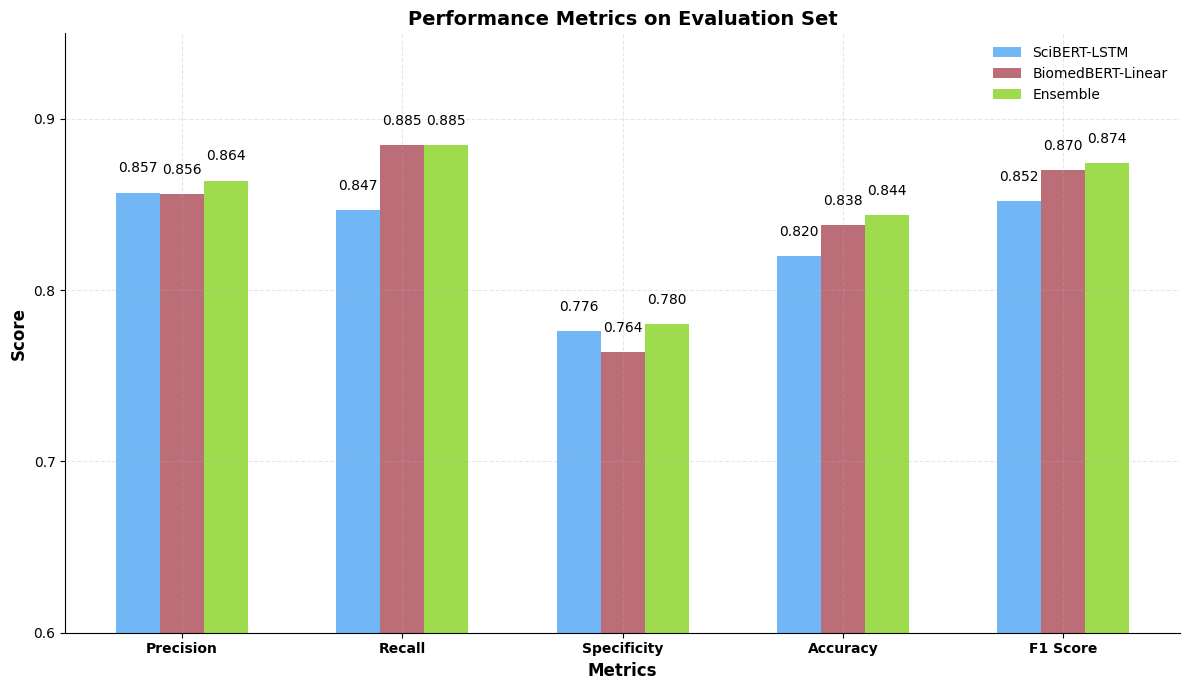

In [11]:
import matplotlib.pyplot as plt
import numpy as np

# Data
scibert = {'Precision': 0.857, 'Recall': 0.847, 'Specificity': 0.776, 'Accuracy': 0.820, 'F1 Score': 0.852}
biomedbert = {'Precision': 0.856, 'Recall': 0.885, 'Specificity': 0.764, 'Accuracy': 0.838, 'F1 Score': 0.870}
ensemble = {'Precision': 0.864, 'Recall': 0.885, 'Specificity': 0.780, 'Accuracy': 0.844, 'F1 Score': 0.874}

# Set the labels, positions and width for the bars
labels = ['Precision', 'Recall', 'Specificity', 'Accuracy', 'F1 Score']
x = np.arange(len(labels))
width = 0.2

fig, ax = plt.subplots(figsize=(12, 7))

# Define a clean and professional color palette
color1 = '#72B7F5'  # SciBERT color (blue)
color2 = '#BC6E78'  # BiomedBERT color (coral)
color3 = '#9EDB4D'  # Ensemble color (teal)

rects1 = ax.bar(x - width, list(scibert.values()), width, label='SciBERT-LSTM', color=color1)
rects2 = ax.bar(x, list(biomedbert.values()), width, label='BiomedBERT-Linear', color=color2)
rects3 = ax.bar(x + width, list(ensemble.values()), width, label='Ensemble', color=color3)

# Set y-axis limits and ticks
ax.set_ylim([0.65, 0.95])
ax.set_yticks(np.arange(0.6, 1, 0.1))
ax.set_yticklabels([f'{x:.1f}' for x in np.arange(0.6, 1, 0.1)])

# Labels and title
ax.set_xlabel('Metrics', fontsize=12, fontweight='bold')
ax.set_ylabel('Score', fontsize=12, fontweight='bold')
ax.set_title('Performance Metrics on Evaluation Set', fontsize=14, fontweight='bold')

ax.set_xticks(x)
ax.set_xticklabels(labels, fontsize=10, fontweight='bold')

# Grid lines
ax.grid(alpha=0.3, linestyle='--')
ax.grid(True, which='both')
ax.grid(which='minor', alpha=0.1, linestyle=':')

# Remove top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Add a Legend
ax.legend(
    fontsize=10,
    frameon=False,
    loc='upper right',
    bbox_to_anchor=(1, 1),
    bbox_transform=ax.transAxes,
)

# Function to add value labels
def autolabel(rects, fmt='%.3f'):
    for rect in rects:
        height = rect.get_height() 
        ax.text(rect.get_x() + rect.get_width() / 2.,
                height + 0.01,
                fmt % float(height),
                ha='center',
                va='bottom',
                color='black',
                fontsize=10,
        )

# Add value labels
autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

# Adjust layout
plt.tight_layout()
plt.savefig('plots/metrics_comparison.png', dpi=600, bbox_inches='tight')
plt.show()